In [2]:
import scola

In [109]:
import numpy as np
import pandas as pd

# Load the log return of the stock prices
log_return = pd.read_csv("https://raw.githubusercontent.com/skojaku/scola/develop/data/sp500-log-return.csv", sep="\t")

L = log_return.shape[0]
N = log_return.shape[1]
ticker_names = log_return.columns
C_samp = log_return.corr().values


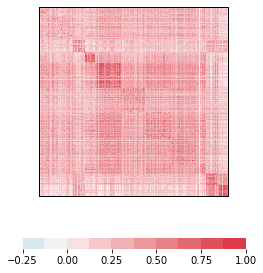

In [178]:
import matplotlib.colors as colors
import seaborn as sns

def plot_corr(A, ax = None, dw = 0.125, cbar_length = .8):

    # Normalize colormap
    min_w = np.min(np.triu(A))
    max_w = np.max(np.triu(A))
    disc_min_w = dw * np.floor(min_w / dw)
    disc_max_w = dw * np.ceil(max_w / dw)
    bounds = np.linspace( disc_min_w, disc_max_w, np.round( (disc_max_w - disc_min_w) / dw) + 1 )
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    # Draw heatmap
    ax = sns.heatmap(A, cmap=cmap,\
                     center = 0,\
                     vmax=max_w,\
                     vmin=min_w,\
                     square=True,\
                     mask=A==0,\
                     cbar_kws = dict(use_gridspec=False,location="bottom", shrink=cbar_length),\
                     norm=norm,\
                     ax = ax\
                    )

    ax.set_xticks([])
    ax.set_yticks([])
    
    # Draw frame
    ax.axhline(y=0, color='k',linewidth=2)
    ax.axhline(y=A.shape[1], color='k',linewidth=2)
    ax.axvline(x=0, color='k',linewidth=2)
    ax.axvline(x=A.shape[0], color='k',linewidth=2)
    
    return ax

fig = plt.figure(figsize=(5, 5))
ax = plt.gca()
plot_corr(C_samp, ax = ax)

plt.savefig("fig/C_samp-sp500.png", bbox_inches = "tight", dpi = 300)


In [10]:
null_models = ["white-noise", "hqs", "config"]
Results = {}
for null_model in null_models:
    W, C_null, selected_null_model, EBIC,construct_from, all_networks\
        = scola.corr2net.transform(C_samp, L, null_model = null_model)
    
    Results[null_model] = {"W":W, "EBIC":EBIC}
    

100%|██████████| 13/13 [01:59<00:00,  9.16s/it]


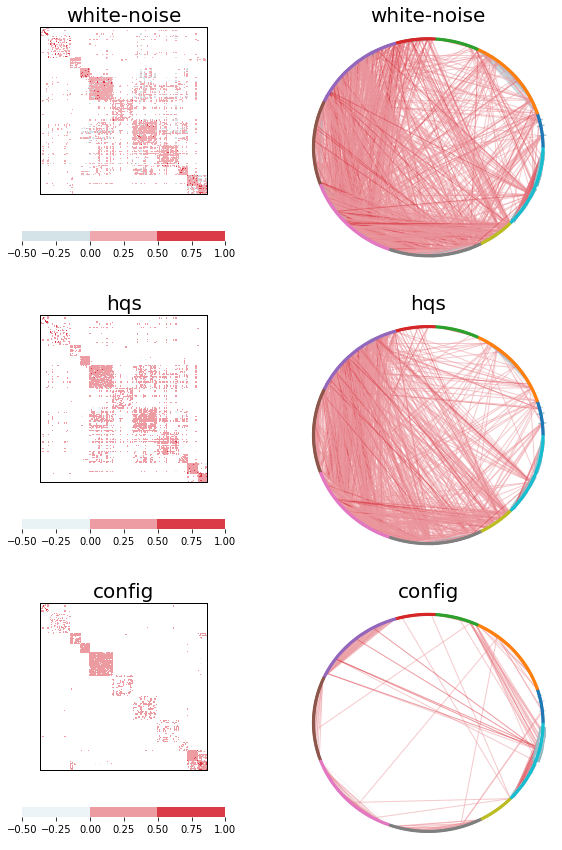

In [166]:
import matplotlib.colors as colors
from matplotlib import cm
import networkx as nx

def draw_network(W, ax = None, dw = 0.25):
    
    G = nx.from_numpy_array(W)
    pos = nx.circular_layout(G)
    
    edge_weight = np.array([ d[2]["weight"] for d in G.edges(data=True)])
    min_w = np.min(np.triu(W,1))
    max_w = np.max(np.triu(W,1))
    disc_min_w = dw * np.floor(min_w / dw)
    disc_max_w = dw * np.ceil(max_w / dw)
    
    bounds = np.linspace( disc_min_w, disc_max_w, np.round( (disc_max_w - disc_min_w) / dw) + 1 )
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    
    edge_cmap = sns.diverging_palette(10, 220, as_cmap=True)
    edge_width_list = np.maximum( np.power( np.abs(edge_weight) / (max_w), 2 ) * 8, 1)
    
    edge_color_list = [ edge_cmap(norm(w)) for w in edge_weight]
    
    nx.draw_networkx_nodes(G, pos,\
                           cmap="tab10",\
                           node_color = sector_ids,\
                           node_size = 5,\
                           ax = ax)
    
    nx.draw_networkx_edges(G, pos,\
                           edge_color=edge_color_list,\
                           width=edge_width_list,\
                           alpha = 0.5,\
                           edge_vmin = min_w,\
                           edge_vmax = max_w,\
                           connectionstyle='arc3, rad=0.3',\
                           ax=ax)
    ax.axis('off')


fig, axes = plt.subplots(nrows = 3, ncols =2, figsize=(10, 15))

for i, null_model in enumerate(null_models):
    W = Results[null_model]["W"]
    plot_corr(W, ax=axes[i,0], dw=0.5)
    axes[i,0].set_title(null_model, fontsize = 20)


# Get sector label 
ticker_sector = pd.read_csv("https://raw.githubusercontent.com/skojaku/scola/develop/data/ticker-sector.csv", sep="\t")
sectors = ticker_sector.set_index("name").loc[ticker_names]
sectors, sector_ids = np.unique(sectors, return_inverse = True)

for i, null_model in enumerate(null_models):
    W = Results[null_model]["W"]
    draw_network(W, ax = axes[i,1])
    axes[i,1].set_title(null_model, fontsize = 20)
plt.savefig("fig/W-sp500-net-all.png", bbox_inches = "tight", dpi = 300)
plt.show()

In [ ]:
import networkx as nx

G = nx.from_numpy_array( np.abs(W) )
pos = np.circular_layout(G)

ticker_names.head()

In [169]:
for null_model in null_models:
    print("%s: EBIC = %f" % (null_model, Results[null_model]["EBIC"]))


white-noise: EBIC = 1239048.769948
hqs: EBIC = 1153825.929170
config: EBIC = 1128540.985291


In [175]:
C_null_wn, K_null_wn, name_wn = scola.null_models.white_noise_model(C_samp)
C_null_hqs, K_null_hqs, name_hqs = scola.null_models.hqs_model(C_samp)
C_null_config, K_null_config, name_config = scola.null_models.configuration_model(C_samp)


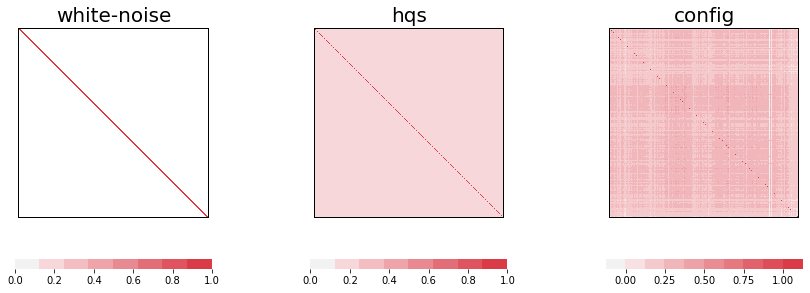

In [183]:
fig, axes = plt.subplots(nrows = 1, ncols =3, figsize=(15, 5))
plot_corr(C_null_wn, ax=axes[0])
axes[0].set_title("white-noise", fontsize = 20)

plot_corr(C_null_hqs, ax=axes[1])
axes[1].set_title("hqs", fontsize = 20)

plot_corr(C_null_config, ax=axes[2])
axes[2].set_title("config", fontsize = 20)

plt.savefig("fig/null_models-sp500.png", bbox_inches="tight", dpi = 300)